![Title](Images/cisco.png)

# Lab - Internet Meter Anomaly Detection <font color='red'>(Instructor Version)</font>
<p>
<font color='red'>**Instructor Note**: Red font color and completed code cells indicate that the information appears in the instructor copy only.</font>

### Objectives
<li>**Part 1: Feature Engineering**</li>
<li>**Part 2: Euclidean Anomaly Detection**</li>
### Scenario/Background
Anomaly-detection algorithms locate those datapoints that stand out from a pattern. For example, algorithms of this kind can be used to test the safety of airplane engines by recording quantities such as fuel consumption, temperature, and so on. Whenever the measurements display extreme values, such as unusually high temperature, anomaly detection alerts the operator, who can then take action to resolve potential issues. Constant improvement of safety standards is not unique to the transport sector, and these algorithms find applications in all branches of industry, from food manufacturing to the production of toys for children. 
### Required Resources
* 1 PC with Internet access
* Raspberry Pi version 2 or higher
* Python libraries: numpy, pandas, matplotlib
* Datafiles: rpi_data_processed.csv


## Part 1 : Feature Engineering

#### Step 1: Import Python Libraries.
In this step, you will import Python libraries.

In [2]:
# Code Cell 1
import numpy as np
import pandas as pd

#### Step 2: Create a Dataframe and modify the quantities.
The quantities that are recorded when gathering data, also known as features, may require some transformation before analysis. For example, the quantity called 'ping' obtained when measuring internet speed. This feature describes intervals of time. A contrast is then observed, as the other quantities being monitored, namely the rates of download and upload, have dimensions of **inverse** time. Because of this, 'ping' is not the optimal choice for statistical analysis. Better results are achieved using a related feature, which we will call 'ping rate'. This is calculated by applying the simple transformation $$\mathrm{ping\ rate} = \frac{1}{\mathrm{ping\ time}}.$$
This process of 'modifying' quantities in view of analysis is termed 'feature engineering', and is generally an important part of the machine-learning workflow. 

Load the internet-speed data from the file `rpi_data_processed.csv` into a Pandas dataframe named `df`. Using this as a starting point,  generate another dataframe, `df_rates`, whose three columns are `download_rate`, `upload_rate` and `ping_rate` respectively. When computing this last feature, make sure that the result is given in units of `1/seconds`.

In [3]:
#Code Cell 2
# Load internet speed data
df = pd.read_csv('./Data/rpi_data_processed.csv')

# Initialize dataframe df_rates
df_rates = df.drop(['Ping (ms)', 'Date', 'Time'], axis=1)

# Rename the download and
# upload columns of df_rates
lookup = {'Download (Mbit/s)': 'download_rate', 
          'Upload (Mbit/s)': 'upload_rate'}
df_rates = df_rates.rename(columns = lookup)

# Calculate ping_rate
ping_rate = 1. / df['Ping (ms)']

# Convert ping_rate to 1/seconds
ping_rate = 1000. * ping_rate

# Add a column to complete the task
df_rates['ping_rate'] = ping_rate

In [4]:
#Code Cell 3
# SOLUTION:
# Inspect the result
df_rates.describe()

,upload_rate,download_rate,ping_rate
count,673.000000,673.000000,673.000000
mean,13.697608,90.449212,48.657348
std,1.080471,3.465647,6.030512
min,6.210000,58.480000,13.067113
25%,13.640000,90.220000,45.781257
50%,13.980000,91.560000,49.207755
75%,14.180000,92.070000,52.314936
max,14.550000,92.870000,61.854395


#### Step 3:  Visualize the Data.

It is reasonable to expect that the measured values of `download_rate`, `upload_rate` and `ping_rate` are concentrated around their averages. Observe the visualization below to see this. Use the sliders to change the angle and azimuth of the plot.

**Optional** <br>
Because internet-speed data only involve three different quantities, they are particularly simple to visualize. Machine-learning systems often exploit tens or even hundreds of features, which makes it difficult to create insightful plots. While drawing eloquent figures is not possible in many situations, interactive visualizations remain a great way of presenting data in front of an audience. You may then want to read and understand the code below, with the help of two comments: 

* The class `Axes3D` from `mpl_toolkits.mplot3d` allows you to generate 3-dimensional plots, extending the functionalities of the familiar `matplotlib.pyplot` module. 
* The method `interact`, which plays crucial role in animating the visualization, is obtained from `ipywidgets`. This module, in turn, is part of the `Ipython` environment for running Python interactively.  

In [5]:
# Code Cell 4
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

In [6]:
# Code Cell 5
def scatter_view(x, y, z, azim, elev):
    # Init figure and axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    # Compute scatter plot
    ax.scatter(x, y, z)
    ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
    ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
    ax.set_zlabel('P rate (1/s)', fontsize=16)
    
    # Specify azimuth
    # and elevation
    ax.azim = azim
    ax.elev = elev

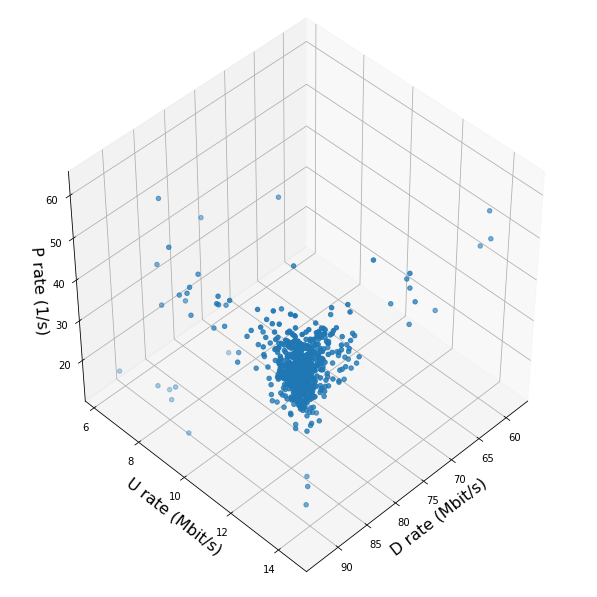

In [7]:
# Code Cell 6
# Draw interactive plot
xi = df_rates['download_rate']
yi = df_rates['upload_rate']
zi = df_rates['ping_rate']
interact(lambda azim, elev: scatter_view(xi, yi, zi, azim, elev),
         azim=(0, 90), elev=(0, 90))
plt.show()

## Part 2: Euclidean Anomaly Detection

As illustrated in the 3-dimensional plot above, anomalies are located far away from the 'average point'. The anomaly-detection system that we will discuss exploits this idea. Points that lie beyond a certain distance from the average will be considered anomalous, whereas all other will be deemed normal. 

For the sake of brevity, let us represent the coordinates `[download_rate, upload_rate, ping_rate]` of a datapoint as  $\{x, y, z\}$. Then, the distance of a measurement from the average location $\{\mu_{x}, \mu_{y}, \mu_{z}\}$ is given by this formula:

$$d = \sqrt{(x - \mu_x)^2 + (y-\mu_y)^2 + (z - \mu_z)^2},$$ 

This is the main ingredient of the anomaly detection system that we will build. As an aside, this ordinary concept of distance is termed **Euclidean**, to distinguish it from possible generalizations. Points such that $x$, $y$, or $z$ differ appreciably from the averages $\mu_{x}$, $\mu_{y}$, and $\mu_{z}$, can be regarded as anomalies. 

#### Step 1: Calculate the means.
Using a suitable Pandas function, calculate the list `mu`, whose elements are the average download, upload and ping rates. 

In [8]:
# Code Cell 7
mu = df_rates.mean()

#### Step 2: Calculate the Euclidean distance.
Find the Euclidean distance between each point and the average location. You may resort to the Numpy functions `np.square` and `np.sqrt`. These compute the [element-wise](http://www.glue.umd.edu/afs/glue.umd.edu/system/info/olh/Numerical/Matlab_Matrix_Manipulation_Software/Matrix_Vector_Operations/elementwise) square power and square root of any input array. Using element-wise functions makes it possible to calculate the distances without `for`-loops that iterate over the datapoints. 

In [9]:
# Code Cell 8
euclid_sq = np.square(df_rates - mu).sum(axis=1)
euclid = np.sqrt(euclid_sq)

#### Step 3: Create a histogram.
Create a histogram of the distance separating each datapoint from the average location. Anomalies are then easily recognized in the 'tail' of the histogram. 

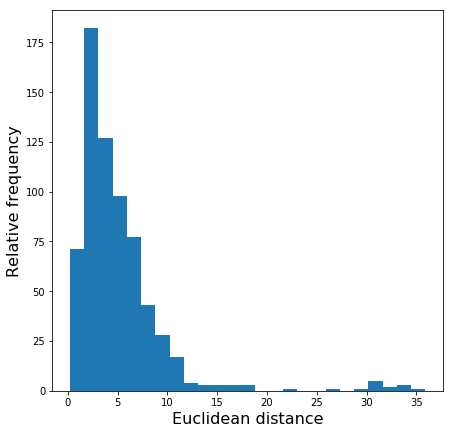

In [10]:
# Code Cell 9
# Histogram of Euclidean distance
fig = plt.figure(figsize=(7, 7))
#SOLUTION:
plt.hist(euclid, 25)

plt.xlabel('Euclidean distance', fontsize=16)
plt.ylabel('Relative frequency', fontsize=16)
plt.show()

#### Step 4: Compute the normalized distance.
It is helpful to work in terms of a **normalized distance**. This is the ratio of each distance over the maximum value of $d$. The furthest anomalous points, then, have a normalized distance of 1. Compute the normalized Euclidean distance for every point in the dataset. 

In [11]:
# Code Cell 10
# Compute normalized Euclidean distance
# SOLUTION:
max_euclid = euclid.max()
nmd_euclid = [float(x)/max_euclid for x in euclid]

#### Step 5: Visualize the alarm rate.
In order to label the points as normal and anomalous, you must define a **decision boundary**. It is necessary to select the distance beyond which points are deemed atypical. While the position of the boundary can be fixed on the basis of qualitative considerations, a quantitiative approach seems preferable. You can gradually increase decision distance, and monitor how the alarm rate varies. Specifically, the alarm rate is the number of anomalies divided by the total number of datapoints. This procedure 'tries out' all possible decision boundaries, allowing us to select the most appropriate one. 

Vary the normalized decision distance from 0 to 1, and record the alarm rate at each step. Store the values of normalized distance and alarm rate in the lists `nmd_range` and `ecl_alarm_rate` respectively. To visualize these results,  generate a plot. 

In [12]:
# Code Cell 11
# Get alarm rate as a function
# of normalized decision distance
ecl_alarm_rate = []
nmd_range = np.linspace(0, 1, 400)
for nmd_decision in nmd_range:
    # Count the number of values with a higher euclidean distance than 
    # the current decision boundary 
    # SOLUTION:
    num_fail = (nmd_euclid > nmd_decision).sum()
    ecl_alarm_rate.append(float(num_fail) / len(euclid))

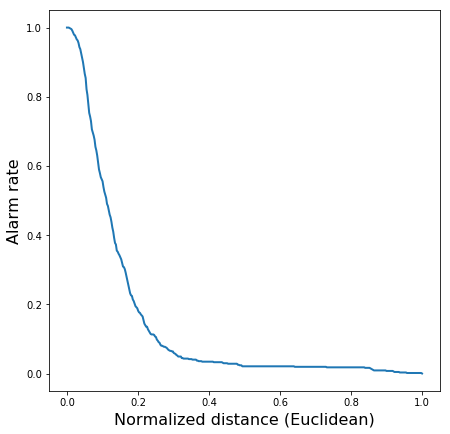

In [13]:
# Code Cell 12
# Plot number of alarms as a 
# function of decision distance
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)
plt.show()

#### Step 6: Select the decision boundary.
The plot above converts the problem of fixing a decision boundary in that of selecting the alarm rate. This is advantageous because the domain of application typically determines a sensible choice for the alarm rate. For example, when testing the safety of aeroplane engines, we may want to choose the alarm rate to be relatively high, so that both major and minor anomalies are detected, and the level of risk is kept low. 

Assume that, for this specific use-case, the optimal alarm rate is 0.1. Find the smallest normalized decision distance (`ecl_decision`) so that the alarm rate falls strictly below the threshold. Because the alarm rate at the selected decision boundary will not be precisely 0.1, store the exact rate in the variable `ecl_threshold`. 


In [14]:
# Code Cell 13
# Select decision boundary
threshold = 0.1
index, ecl_threshold = next(tpl for tpl in enumerate(ecl_alarm_rate) if tpl[1] < threshold)
ecl_decision = nmd_range[index]

#### Step 7: Visualize the decision boundary.
Generate the plot from step 5 again, using a dot to mark the location of the decision boundary. 

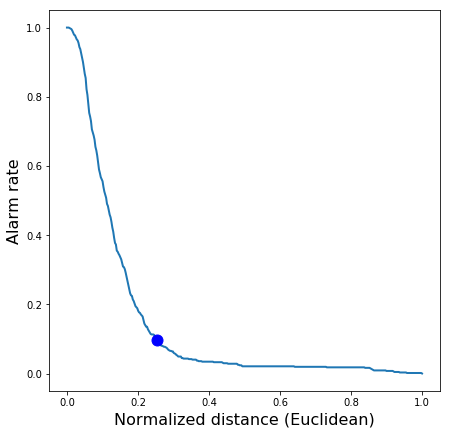

In [15]:
#Code Cell 14
# Alarm rate with decision boundary
fig = plt.figure(figsize=(7, 7))
# SOLUTION:
# Plot the alarm rate as a function of the normalized euclidean distance
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
# Plot the chosen decision threshold and the curresponding alarm rate
plt.plot(ecl_decision, ecl_threshold, 'bo', markersize=11)

plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)
plt.show()

#### Step 8: Visualize the decision boundary in 3D.
Because our anomaly detection algorithm makes use of Euclidean distances, its decision boundaries, when visualized in three dimensions, are spherical. Examine the plot below to see this. We would also encourage you to read and understand the associated code. 

In [16]:
#Code Cell 15
# Decision sphere (Polar coordinates)
radius = ecl_decision * max_euclid
phi = np.linspace(0, 2 * np.pi, 300)
theta = np.linspace(0, 2 * np.pi, 300)

# Decision sphere (Cartesian coordinates)
xs = radius * np.outer(np.sin(theta), np.cos(phi))
ys = radius * np.outer(np.sin(theta), np.sin(phi))
zs = radius * np.outer(np.cos(theta), np.ones(np.size(phi)))

# Center decision sphere at mean
ecl_xd = xs + df_rates['download_rate'].mean()
ecl_yd = ys + df_rates['upload_rate'].mean()
ecl_zd = zs + df_rates['ping_rate'].mean()

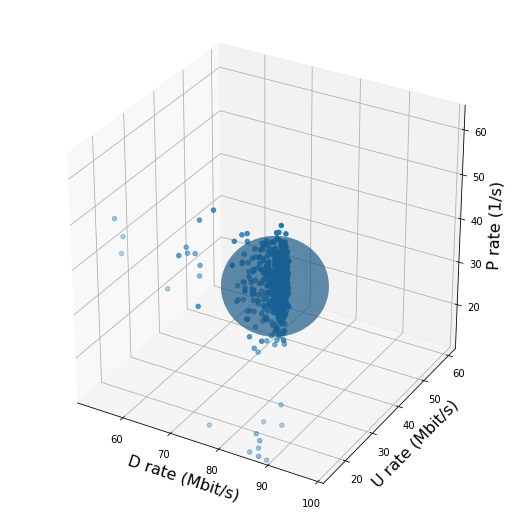

In [17]:
#Code Cell 16
# Init figure and axes
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

# Plot data
ax.scatter(df_rates['download_rate'],
           df_rates['upload_rate'], 
           df_rates['ping_rate'])

# Plot decision boundary
ax.plot_surface(ecl_xd, ecl_yd, ecl_zd,
                linewidth=0, alpha=0.25)

# Label axes
ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
ax.set_zlabel('P rate (1/s)', fontsize=16)
    
# --------------------------------------------------
# Set equal aspect ratio for all axes
# --------------------------------------------------

# Extreme values of x, y, z
extremes = []
extremes.append([df_rates['download_rate'].min(),
                 df_rates['download_rate'].max()])
extremes.append([df_rates['upload_rate'].min(),
                 df_rates['upload_rate'].max()])
extremes.append([df_rates['ping_rate'].min(),
                 df_rates['ping_rate'].max()])

# Half-widths and mid-points
hwidths = [(row[1] - row[0]) / 2.0 for row in extremes]
midpts = [(row[1] + row[0]) / 2.0 for row in extremes]

# Set xlim, ylim, zlim
left_ends = midpts - np.max(hwidths)
right_ends = midpts + np.max(hwidths)
ax.set_xlim([left_ends[0], right_ends[0]]);
ax.set_ylim([left_ends[1], right_ends[1]]);
ax.set_ylim([left_ends[2], right_ends[2]]);

<font size='0.5'>&copy; 2017 Cisco and/or its affiliates. All rights reserved. This document is Cisco Public.<font>